# Notebook to check the DR9 SV imaging

In [88]:
import os 
import glob
import h5py
import ephem
import fitsio
import numpy as np 
import pylab as pl

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from   desimodel.io import load_tiles
from   astropy.time import Time, TimeDelta
from   astropy.table import Table
from   desimodel.footprint import is_point_in_desi

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [70]:
# local directory with data
dat_dir    = '/global/cfs/cdirs/desi/users/chahah/'
out_dir    = '/global/cscratch1/sd/mjwilson/trash/'

### Read parent DESI tile

In [119]:
# pick the rest of the tiles from desi-tiles.fits far from the selected tiles 
desi_tiles = load_tiles(onlydesi=False)

imaging    = Table(desi_tiles[desi_tiles['IN_IMAGING'] == 1], copy=True)
imaging    = imaging[imaging['PASS'] == 5]['RA', 'DEC']

desi_tiles = desi_tiles[desi_tiles['PASS'] == 5]
desi_tiles = desi_tiles[desi_tiles['IN_DESI'] == 1]

### Abell

In [120]:
abell      =  Table.read('/global/cfs/cdirs/desi/sv/bgs/bgs-cmxsv/dat/abell.dat', format='ascii', names=['Name', 'RA', 'DEC']) 

In [121]:
isin       =  is_point_in_desi(imaging, abell['RA'], abell['DEC'], return_tile_index=False)

In [122]:
np.count_nonzero(isin), len(isin)

(24, 29)

In [126]:
abell_veto = abell[~isin]
abell      = abell[isin]

In [127]:
abell_veto

Name,RA,DEC
str9,float64,float64
Abell0401,44.0465,13.3833
Abell0399,44.4807,13.0109
Abell0478,63.3415,10.471
Abell2319,290.2,43.9765
Abell2092,309.658,41.3847


### DES supernovae fields

In [173]:
des_sn = Table.read('/global/cfs/cdirs/desi/sv/bgs/bgs-cmxsv/dat/des-supernovae.dat', format='ascii', names=['FIELD', 'RA', 'DEC', 'DEPTH']) 
des_sn

FIELD,RA,DEC,DEPTH
str2,float64,float64,str7
X1,34.4757,-4.9295,shallow
X2,35.6645,-6.4121,shallow
X3,36.45,-4.6,deep
S1,42.82,0.0,shallow
S2,41.1944,-0.9884,shallow


### Read in DR9SV imaging targets

In [128]:
dr9sv = fitsio.read(os.path.join(dat_dir, 'sv1-targets-dr9-hp-X.fits'))

In [129]:
def get_moons():
    moon  = ephem.Moon()

    start = Time('2020-01-01', format='iso')
    moons = []

    for day in range(365):
        night = start + day * TimeDelta(1., format='jd')
        night = night.isot.replace('-', '/').replace('T',' ').split('.')[0]
    
        moon.compute(night)
        moons.append([moon.ra, moon.dec])
    
    moons       = np.array(moons)
    moons[:,0] *= 180. / np.pi
    moons[:,1] *= 180.
    
    return moons

In [130]:
moons = get_moons()

In [184]:
def plot_context(ax, moons, tiles):
    ax.plot(des_sn['RA'], des_sn['DEC'], c='r', markersize=5, label='DES SN')
    
    ax.plot(moons[:,0], moons[:,1], c='k', alpha=0.8, marker='.', lw=0.0, markersize=1)
    
    ax.plot(tiles['RA'], tiles['DEC'], lw=0.0, marker='.', alpha=0.5, c='dodgerblue')
    
    ax.plot(imaging['RA'], imaging['DEC'], lw=0.0, marker='.', alpha=0.1, c='k')

    ax.scatter(abell['RA'], abell['DEC'], c='maroon', s=3, label='Abell')
    ax.scatter(abell_veto['RA'], abell_veto['DEC'], c='maroon', s=15, marker='x')
    
    pl.axhline(y=32.375, xmin=0., xmax=1., lw=1.0, c='k')

### Currently specified regions

In [185]:
sv_regions = {}

In [186]:
sv_regions['01_s82']            = '30,40,-7,2'
sv_regions['02_egs']            = '210,220,50,55'
sv_regions['03_gama09']         = '129,141,-2,3'
sv_regions['04_gama12']         = '175,185,-3,2'
sv_regions['05_gama15']         = '212,222,-2,3'
sv_regions['06_overlap']        = '135,160,30,35'
sv_regions['07_refnorth']       = '215,230,41,46'
sv_regions['08_ages']           = '215,220,32.4,40'
sv_regions['09_sagittarius']    = '200,210,5,10'
sv_regions['10_highebv_n']      = '140,150,65,70'
sv_regions['11_highebv_s']      = '240,245,20,25'
sv_regions['12_highstardens_n'] = '273,283,40,45'
sv_regions['13_highstardens_s'] = '260,270,15,20'

In [187]:
# Table 2 of SV plan. 
# sv_regions['14_BMZLSDES']       = '35,43,-2,3'
# sv_regions['15_hdfn']           = '187,191,61,63'
# sv_regions['16_nep']            = '260,280,60,70'
# ...

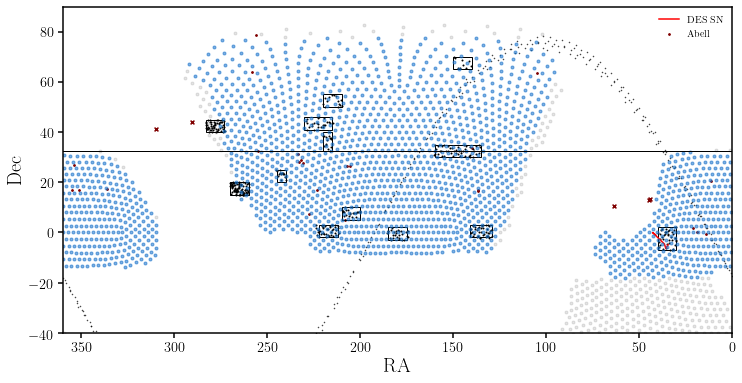

In [188]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

sub.scatter(dr9sv['RA'][::10000], dr9sv['DEC'][::10000], c='k', s=1)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend()

### Regions we want *outside* of DR9SV imaging

In [56]:
omitted_regions                      = {} 
omitted_regions['PRIMUS-COSMOS']     = '149.6,150.7,1.8,2.9'
omitted_regions['PRIMUS-CDFS-SWIRE'] = '51.8,54.4,-29.7,-28.0'

(-40.0, 90.0)

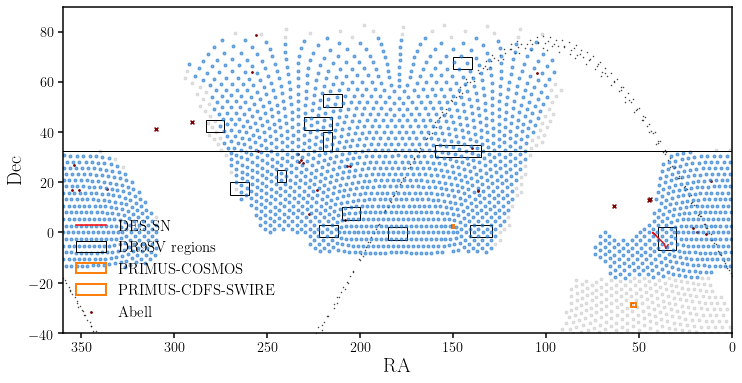

In [189]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 
    
sub.legend(loc='lower left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

Lets compare the DR9 SV footprint to the old BGS SV fields

In [58]:
sv_old = fitsio.read(os.path.join(dat_dir, 'BGS_SV_30_3x_superset60_Sep2019.fits')) 

(-40.0, 90.0)

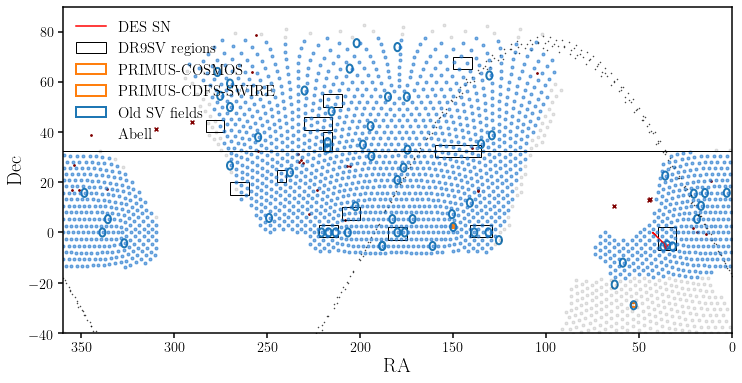

In [198]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 

for i in range(len(sv_old['RA'])): 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='C0', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='C0', facecolor='none', linewidth=2, label='Old SV fields') 
sub.add_patch(circ) 
        
sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

Overall, there's very little overlap with the DR9 SV fields. First, lets keep all the old tiles that are in the SV regions and the PRIMUS regions.

In [60]:
# keep fields that already fall into regions 
print('out of %i fields' % len(sv_old['RA']))

keep = np.zeros(len(sv_old['RA'])).astype(bool) 

for reg in sv_regions.keys(): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])
    inkeep = (
            (sv_old['RA'] - 1.6275 > ra_min) & (sv_old['RA'] + 1.6275 < ra_max) & 
            (sv_old['DEC'] - 1.6275 > dec_min) & (sv_old['DEC'] + 1.6275 < dec_max)
            )    
    keep = keep | inkeep
print('keeping %i previous fields in DR9SV regions' % np.sum(keep))

for reg in omitted_regions.keys(): 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])
    inkeep = (
            (sv_old['RA'] > ra_min) & (sv_old['RA'] < ra_max) & 
            (sv_old['DEC'] > dec_min) & (sv_old['DEC'] < dec_max)
            ) 
    keep = keep | inkeep 
print('keeping %i previous fields including omitted regions' % np.sum(keep))

out of 60 fields
keeping 6 previous fields in DR9SV regions
keeping 8 previous fields including omitted regions


(-40.0, 90.0)

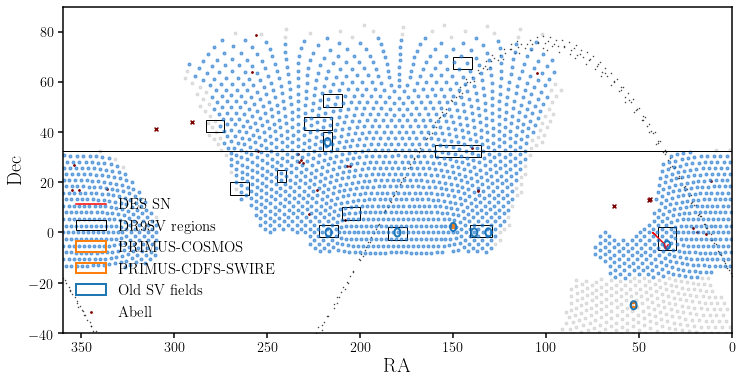

In [191]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='C0', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='C0', facecolor='none', linewidth=2, label='Old SV fields') 
sub.add_patch(circ) 
        
sub.legend(loc='lower left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

Now lets put as many new BGS SV tiles in the DR9SV fields

44 new SV fields in DR9SV regions
52 total tiles assigned so far


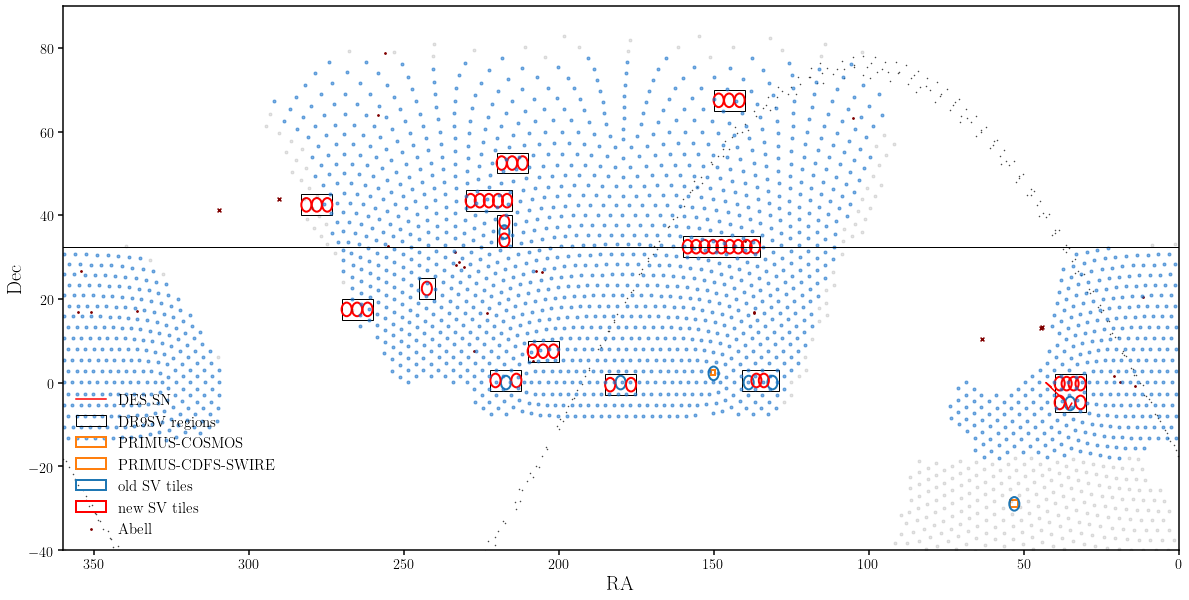

In [192]:
# put SV tiles on high EBV regions and high star density 
ra_new, dec_new = [], [] 
for reg in sv_regions.keys(): 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    if reg == '11_highebv_s': 
        ra_new.append([0.5*(ra_min + ra_max)])
        dec_new.append([0.5*(dec_min + dec_max)])
    elif reg == '08_ages': 
        _dec = [dec_min+1.63, dec_max-1.63]
        _ra = [0.5*(ra_min + ra_max) for _ in _dec]
        ra_new.append(_ra)
        dec_new.append(_dec) 
    elif reg == '01_s82':
        i_ra = np.floor(((ra_max - ra_min) - 2. * 1.63) / (1.25*1.63))
        dra = (ra_max - ra_min - 2. * 1.63) / i_ra
        _ra = [ra_min + 1.63 + dra * i for i in range(int(i_ra)+1)]
        _dec = [0.25*dec_min + 0.75*dec_max  for _ in _ra]
        ra_new.append(_ra)
        dec_new.append(_dec) 
        
        _ra = [ra_min + 1.63, ra_max - 1.63]
        _dec = [0.75*dec_min + 0.25*dec_max  for _ in _ra]
        ra_new.append(_ra)
        dec_new.append(_dec) 
    elif reg == '04_gama12': 
        ra_new.append([ra_min + 1.63, ra_max - 1.63])
        dec_new.append([0.5*(dec_min + dec_max), 0.5*(dec_min + dec_max)])
    elif reg == '03_gama09': 
        ra_new.append([0.5 * (ra_min + ra_max)-1.2, 0.5 * (ra_min + ra_max)+1.2])
        dec_new.append([0.5 * (dec_min + dec_max), 0.5 * (dec_min + dec_max)])
    elif reg == '05_gama15':
        ra_new.append([ra_min + 1.63, ra_max - 1.63])
        dec_new.append([0.5 * (dec_min + dec_max), 0.5 * (dec_min + dec_max)])
    elif reg == '06_overlap': 
        i_ra = np.floor(((ra_max - ra_min) - 2. * 1.63) / (1.25*1.63)) - 2
        dra = (ra_max - ra_min - 2. * 1.63) / i_ra
        _ra = [ra_min + 1.63 + dra * i for i in range(int(i_ra)+1)]
        ra_new.append(_ra)
        dec_new.append([0.5*(dec_min + dec_max) for _ in _ra]) 
    else: 
        i_ra = np.floor(((ra_max - ra_min) - 2. * 1.63) / (1.25*1.63)) - 1
        dra = (ra_max - ra_min - 2. * 1.63) / i_ra
        _ra = [ra_min + 1.63 + dra * i for i in range(int(i_ra)+1)]
        ra_new.append(_ra)
        dec_new.append([0.5*(dec_min + dec_max) for _ in _ra]) 
        
ra_new = np.concatenate(ra_new)
dec_new = np.concatenate(dec_new)
print('%i new SV fields in DR9SV regions' %  len(ra_new)) 

fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='C0', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='C0', facecolor='none', linewidth=2, label='old SV tiles') 
sub.add_patch(circ) 
        
for i in np.arange(len(ra_new)): 
    circ = patches.Circle((ra_new[i], dec_new[i]), radius=1.6275, edgecolor='r', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='r', facecolor='none', linewidth=2, label='new SV tiles') 
sub.add_patch(circ)     
    
sub.legend(loc='lower left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
print('%i total tiles assigned so far' % (np.sum(keep) + len(ra_new)))

In [63]:
np.random.seed(1)
n_left = 60 - (np.sum(keep) + len(ra_new))

In [64]:
keeptile = np.ones(desi_tiles.shape[0]).astype(bool)
keeptile &= (desi_tiles['IN_DESI'] == 1) & (desi_tiles['PASS'] == 5)

for ra, dec in zip(ra_new, dec_new): 
    _keep = ((desi_tiles['RA'] - ra)**2 + (desi_tiles['DEC'] - dec)**2 > 400.)
    keeptile = keeptile & _keep
    
for ra, dec in zip(sv_old['RA'][keep], sv_old['DEC'][keep]): 
    _keep = ((desi_tiles['RA'] - ra)**2 + (desi_tiles['DEC'] - dec)**2 > 400.)
    keeptile = keeptile & _keep        
    
ra_random, dec_random, i_tiles = [], [], []

for i in range(n_left): 
    new_pick = np.random.choice(np.arange(np.sum(keeptile)), 1, replace=False) 
    _ra, _dec = desi_tiles['RA'][keeptile][new_pick], desi_tiles['DEC'][keeptile][new_pick]
    ra_random.append(_ra) 
    dec_random.append(_dec)
    i_tiles.append(np.arange(len(desi_tiles['RA']))[keeptile][new_pick])
    keeptile = keeptile & ((desi_tiles['RA'] - _ra)**2 + (desi_tiles['DEC'] - _dec)**2 > 400.)

8 random new fields


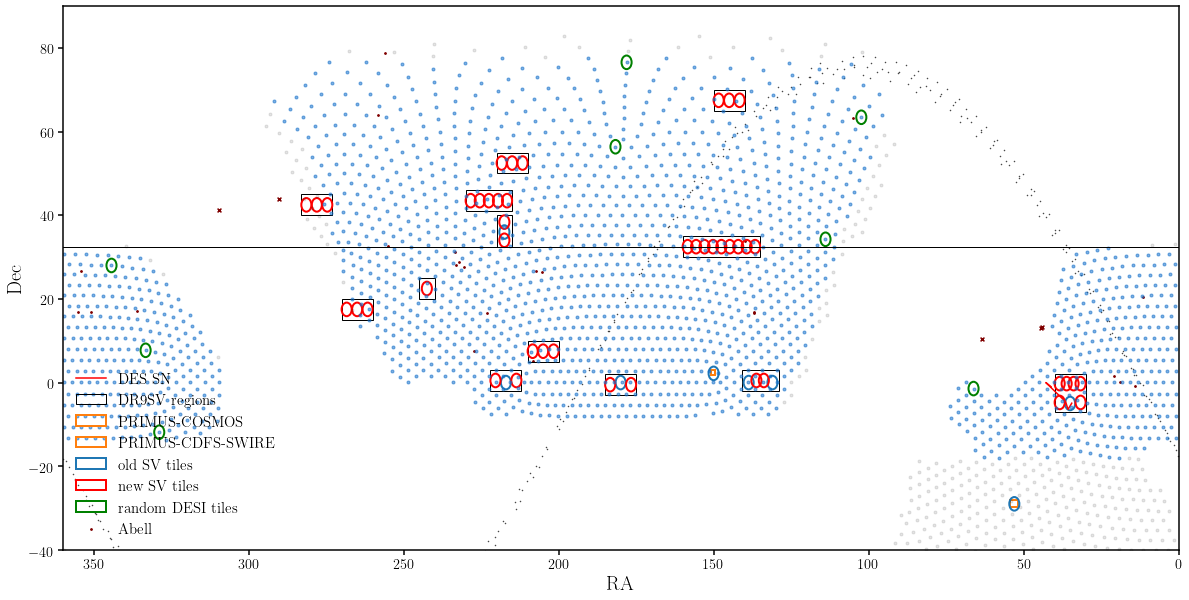

In [193]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='C0', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='C0', facecolor='none', linewidth=2, label='old SV tiles') 
sub.add_patch(circ) 
        
for i in np.arange(len(ra_new)): 
    circ = patches.Circle((ra_new[i], dec_new[i]), radius=1.6275, edgecolor='r', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='r', facecolor='none', linewidth=2, label='new SV tiles') 
sub.add_patch(circ)   

for _ra, _dec in zip(ra_random, dec_random): 
    circ = patches.Circle((_ra, _dec), radius=1.6275, edgecolor='g', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='g', facecolor='none', linewidth=2, label='random DESI tiles') 
sub.add_patch(circ) 
        
    
sub.legend(loc='lower left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

print('%i random new fields' % n_left)

In [66]:
sv_new = sv_old.copy() 

_i = 0

for i in range(len(ra_new)): 
    __i = np.arange(len(sv_new))[~keep][_i]
    sv_new['RA'][__i] = ra_new[i]
    sv_new['DEC'][__i] = dec_new[i]
    _i += 1

for i, i_tile in zip(range(n_left), i_tiles): 
    __i = np.arange(len(sv_new))[~keep][_i]

    for k in desi_tiles.dtype.names: 
        sv_new[k][__i] = desi_tiles[k][i_tile[0]]
    sv_new['RA'][__i] = ra_random[i]
    sv_new['DEC'][__i] = dec_random[i]
    _i += 1

8 random new fields


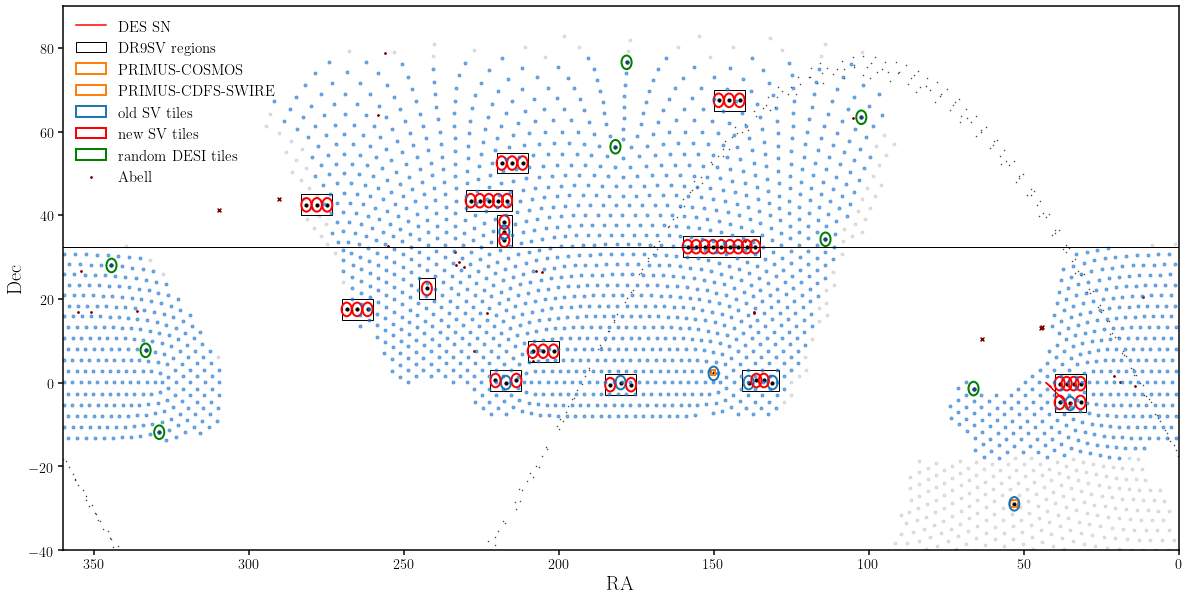

In [194]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='C0', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='C0', facecolor='none', linewidth=2, label='old SV tiles') 
sub.add_patch(circ) 
        
for i in np.arange(len(ra_new)): 
    circ = patches.Circle((ra_new[i], dec_new[i]), radius=1.6275, edgecolor='r', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='r', facecolor='none', linewidth=2, label='new SV tiles') 
sub.add_patch(circ)   

for _ra, _dec in zip(ra_random, dec_random): 
    circ = patches.Circle((_ra, _dec), radius=1.6275, edgecolor='g', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='g', facecolor='none', linewidth=2, label='random DESI tiles') 
sub.add_patch(circ) 

sub.scatter(sv_new['RA'], sv_new['DEC'], c='k', s=10)
    
sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

print('%i random new fields' % n_left)

In [68]:
print('Total number of tiles: {:d}'.format(len(sv_new)))

Total number of tiles: 60


In [71]:
fitsio.write(os.path.join(out_dir, 'BGS_SV_30_3x_superset60_Apr2020v2.fits'), sv_new, clobber=True)

In [72]:
# ! ./up --tiles /global/cscratch1/sd/mjwilson/trash/BGS_SV_30_3x_superset60_Apr2020v2.fits --firstday 20201201 --lastday 20210102 --outdir /global/cscratch1/sd/mjwilson/trash/ --numproc 12

In [81]:
sv_up   = fitsio.read(os.path.join(out_dir, 'up-BGS_SV_30_3x_superset60_Apr2020v2.fits'))

In [84]:
visible = (sv_up['DECEMBER'][:,0] > 0.0) & (sv_up['DECEMBER'][:,2] > 0.0)
sv_up   = sv_up[visible]

print(np.count_nonzero(visible), len(visible))

50 60


8 random new fields


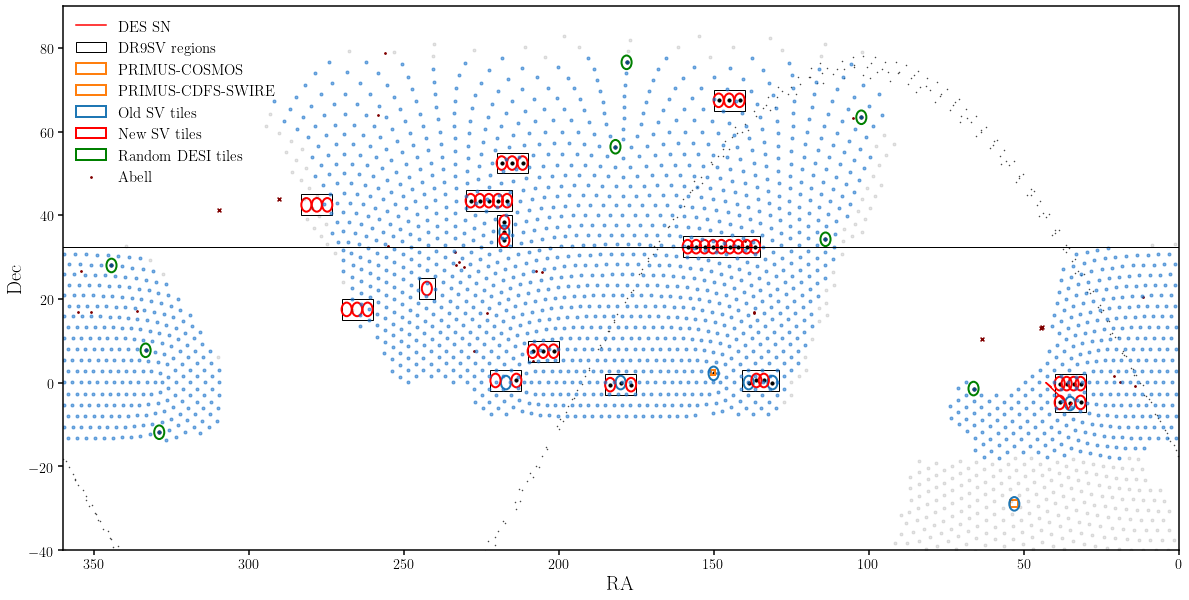

In [197]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
ax  = pl.gca()

plot_context(ax, moons, desi_tiles)

for i, reg in enumerate(sv_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(sv_regions[reg].split(',')[0]), float(sv_regions[reg].split(',')[1])
    dec_min, dec_max    = float(sv_regions[reg].split(',')[2]), float(sv_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=1, edgecolor='k', facecolor='none')
    sub.add_patch(region) 

region = patches.Rectangle((0,0),0,0, linewidth=1, edgecolor='k', facecolor='none', label='DR9SV regions')
sub.add_patch(region) 

for i, reg in enumerate(omitted_regions.keys()): 
    # get RA, Dec range of new SV regions 
    ra_min, ra_max      = float(omitted_regions[reg].split(',')[0]), float(omitted_regions[reg].split(',')[1])
    dec_min, dec_max    = float(omitted_regions[reg].split(',')[2]), float(omitted_regions[reg].split(',')[3])

    region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), 
            linewidth=2, edgecolor='C1', facecolor='none', label=reg)
    sub.add_patch(region) 

for i in np.arange(len(sv_old['RA']))[keep]: 
    circ = patches.Circle((sv_old['RA'][i], sv_old['DEC'][i]), 
                          radius=1.6275, edgecolor='C0', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='C0', facecolor='none', linewidth=2, label='Old SV tiles') 
sub.add_patch(circ) 
        
for i in np.arange(len(ra_new)): 
    circ = patches.Circle((ra_new[i], dec_new[i]), radius=1.6275, edgecolor='r', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='r', facecolor='none', linewidth=2, label='New SV tiles') 
sub.add_patch(circ)   

for _ra, _dec in zip(ra_random, dec_random): 
    circ = patches.Circle((_ra, _dec), radius=1.6275, edgecolor='g', facecolor='none', linewidth=2) 
    sub.add_patch(circ) 
circ = patches.Circle((0, 0), radius=0, edgecolor='g', facecolor='none', linewidth=2, label='Random DESI tiles') 
sub.add_patch(circ) 

sub.scatter(sv_up['RA'], sv_up['DEC'], c='k', s=10)
    
sub.legend(loc='upper left', fontsize=15)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)

print('%i random new fields' % n_left)

# Done.